# Evaluate, optimize, and fit a classifier


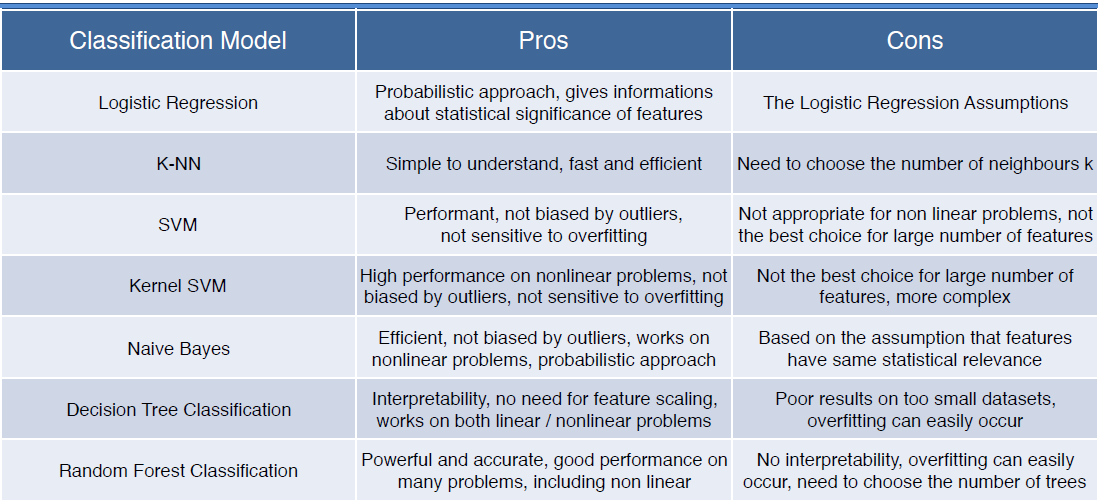## Background

Now that we've extracted training data from the ODC, and inspected it to ensure the features we selected are appropriate and useful, we can train a machine learning model. The first step is to decide which machine learning model to use. Deciding which one to pick depends on the classification task at-hand. The table below provides a useful summary of the pros and cons of different models (all of which are available through [scikit-Learn](https://scikit-learn.org/stable/)). This sckit-learn [cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) may also help.

_Table 1: Some of the pros and cons of different classifiers available through scikit-learn_

<img align="center" src="../../Supplementary_data/Scalable_machine_learning/classifier_pro_cons.png" width="700">

The approach to evaluating, optimizing, and training the supervised machine learning model demonstrated in this notebook has been developed to suit the default training dataset provided.  The training dataset is small, contains geospatial data, and contains only two classes (vegetated wetlands and non-vegetated wetlands). 

* Because the dataset is very small (`n=156` as shown in the [Extracting_training_data](1_Extract_training_data.ipynb) notebook), splitting the data into a training and testing set, and only training the model on the smaller training set would likely substantially degrade the quality of the model. Thus we will fit the final model on _all_ the training data.
* Because we are fitting the model on all the data, we won't have a testing set left over to estimate the model's prediction accuracy. We therefore rely on a method called **nested k-fold cross-validation** to estimate the prediction ability of our model. This method is described further in the markdown before the code.
* And because we are generating a binary prediction (vegetated wetlands/non-vegetated wetlands), the metrics used to evaluate the classifier are those which are well suited to binary classifications.

While the approach described above works well for the default training data provided, it may not suit your own classification problem. It is advisable to research the different methods for evaluating and training a model to determine which approach is best for you.


## Description

This notebook runs through evaluating, optimizing, and fitting a machine learning classifier (in the default example, a Random Forest model is used). Under each of the sub-headings you will find more information on how and why each method is used. The steps are as follows:

1. Set up some parameters and import the training data
2. Calculate an unbiased performance estimate via nested cross-validation
3. Optimize the hyperparameters of the model
4. Fit a model to all the training data using the best hyperparameters identified in the previous step
5. Save the model to disk for use in the subsequent notebook, `4_Classify_satellite_data.ipynb`

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

## Load packages

In [1]:
# -- scikit-learn classifiers, uncomment the one of interest----

#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier


import os
import subprocess as sp
import sys
from pprint import pprint

import dask.array as da
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit

## Analysis Parameters

* The `year`,  `output_dir` and `training_data` are copied from the [`1_Extract_training_data.ipynb`](1_Extract_training_data.ipynb) notebook.
* `training_data`: Name and location of the training data `.txt` file output from runnning the [`1_Extract_training_data.ipynb`](1_Extract_training_data.ipynb) notebook.
* `Classifier`: This parameter refers to the scikit-learn classification model to use, first uncomment the classifier of interest in the `Load Packages` section and then enter the function name into this parameter `e.g. Classifier = SVC`   
* `metric` : A single string that denotes the scorer used to find the best parameters for refitting the estimator to evaluate the predictions on the test set. See the scoring parameter page [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a pre-defined list of options. e.g. `metric='balanced_accuracy'`
* `model_path` : The path to the location where the model will be exported to. 

In [2]:
year = "2017"
output_dir = "results"
training_data = f"{output_dir}/kenya_uganda_test_training_data_{year}.txt"

Classifier = RandomForestClassifier

metric = 'balanced_accuracy'

model_path = f"{output_dir}/ml_model_{year}.joblib"

## K-Fold Cross Validation Analysis Parameters

* `outer_cv_splits` : The number of cross validation splits to use for the outer loop of the nested CV. These splits are used to estimate the accuracy of the classifier. A good default number is 5-10
* `inner_cv_splits` : The number of cross validation splits to use for the inner loop of the nested CV - the inner loop splits are used for optimizing the hyperparameters. A good default number is 5.
* `test_size` : This will determine what fraction of the dataset will be set aside as the testing dataset. There is a trade-off here between having a larger test set that will help us better determine the quality of our classifier, and leaving enough data to train the classifier. A good deafult is to set 10-20 % of your dataset aside for testing purposes.


In [3]:
inner_cv_splits = 5

outer_cv_splits = 5

test_size = 0.20

### Find the number of cpus

In [4]:
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

ncpus = 15


## Import training data

In [5]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

## Calculate an unbiased performance estimate via nested cross-validation

K-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a statistical method used to estimate the performance of machine learning models when making predictions on data not used during training.  It is a popular method because it is conceptually straightforward and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

This procedure can be used both when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. However, when the same cross-validation procedure and dataset are used to both tune and select a model, it is likely to lead to an optimistically biased evaluation of the model performance.

One approach to overcoming this bias is to nest the hyperparameter optimization procedure under the model selection procedure. This is called **nested cross-validation**. The paper [here](https://jmlr.csail.mit.edu/papers/v11/cawley10a.html) provides more context to this issue.  The image below depicts how the nested cross-validation works.

<img align="center" src="../../Supplementary_data/Scalable_machine_learning/nested_CV.png" width="500">

The result of our nested cross-validation will be a set of accuracy scores that show how well our classifier is doing at recognising unseen data points. The default example is set up to show the `balanced_accuracy`, and `f1` scores, along the `Receiver-Operating Curve, Area Under the Curve (ROC-AUC)`. This latter metric is a robust measure of a classifier's prediction ability. [This article](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) has a good explanation on ROC-AUC, which is a common machine learning metric.

All measures return a value between 0 and 1, with a value of 1 indicating a perfect score.

To conduct the nested cross-validation, we first need to define a grid of parameters to be used in the optimization:
* `param_grid`: a dictionary of model specific parameters to search through during hyperparameter optimization.

> **Note**: the parameters in the `param_grid` object depend on the classifier being used. The default example is set up for a Random Forest classifier, to adjust the parameters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html). 

In [6]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [200,300,400],
    'criterion':['gini', 'entropy']
}

In [7]:
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True,
                        random_state=0)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []
i = 1
for train_index, test_index in outer_cv.split(X, y):
    print(f"Working on {i}/5 outer cv split", end='\r')
    model = Classifier(random_state=1)

    # index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    
    # inner split on data within outer split
    inner_cv = KFold(n_splits=inner_cv_splits,
                     shuffle=True,
                     random_state=0)
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=metric,
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)
    # evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    auc_ = roc_auc_score(y_true=y_tt, y_score=probs, multi_class='ovo')
    roc_auc.append(auc_)
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    # F1 scores
    f1_ = f1_score(y_true=y_tt, y_pred=pred, average='micro')
    f1.append(f1_)

    i += 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

### Print the results of our model evaluation

In [8]:
print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))
print("Std F1: "+ str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: "+ str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: "+ str(round(np.std(roc_auc), 2)))
print('=============================================')

=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.58
Std balanced accuracy: 0.01


Mean F1: 0.64
Std F1: 0.01


Mean roc_auc: 0.88
Std roc_auc: 0.02


These scores represent a robust estimate of the accuracy of our classifier. However, because we are using only a subset of data to fit and optimize the models, and the total amount of training data we have is small (only 156 samples in the default example) it is reasonable to expect these scores are an under-estimate of the final model's accuracy.  

Also, the _map_ accuracy will likely differ from the accuracies reported here since the training data is often not a perfect representation of the data in the real world. For example, we may have purposively over-sampled from hard-to-classify regions, or the proportions of classes in our dataset may not match the proportions in the real world. 

## Optimize hyperparameters

Machine learning models require certain 'hyperparameters': model parameters that can be tuned to increase the prediction ability of a model. Finding the best values for these parameters is a 'hyperparameter search' or an 'hyperparameter optimization'.

To optimize the parameters in our model, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through a set of parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined.

We'll search the same set of parameters that we definied earlier, `param_grid`.


In [9]:
#generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)

In [10]:
#instatiate a gridsearchCV
clf = GridSearchCV(Classifier(),
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=rs.split(X, y),
                   n_jobs=ncpus)

clf.fit(X, y)

print('\n')
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The "+metric+" score using these parameters is: ")
print(round(clf.best_score_, 2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


The most accurate combination of tested parameters is: 
{'class_weight': None,
 'criterion': 'entropy',
 'max_features': None,
 'n_estimators': 200}


The balanced_accuracy score using these parameters is: 
0.54


## Fit a model

Using the best parameters from our hyperparmeter optimization search, we now fit our model on all the data.

In [11]:
#create a new model
new_model = Classifier(**clf.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(X, y)

RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=200,
                       n_jobs=15, random_state=1)

## Save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in the subsequent script, `4_Classify_satellite_data.ipynb` 


In [12]:
dump(new_model, model_path)

['results/ml_model_2017.joblib']

## Recommended next steps

To continue working through the notebooks in this `Scalable Machine Learning on the ODC` workflow, go to the next notebook `4_Classify_satellite_data.ipynb.ipynb`.

1. [Extracting_training_data](1_Extract_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. **Evaluate_optimize_fit_classifier (this notebook)**
4. [Classify_satellite_data](4_Classify_satellite_data.ipynb)
5. [Object-based_filtering](5_Object-based_filtering.ipynb)(optional)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).


**Last Tested:**

In [13]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d')

'2023-12-12'